# Assignment 1: ***Knowledge Graph***

#### Instructor: ***Dr. Mohammad Ali Nematbakhsh***
##### Course: *Advanced Software Concepts 2*
##### Teaching Assistant: *Zahra Zandieh Shirazi*
######
##### Student's Name:*Reza Barzegar Nozari*
##### Student ID Number: *4033615005*
##### Isfahan University, Faculty of Computer Engineering
-------------------------------------------------------------------------
## Explanation:
In this exercise, we create a simple ***knowledge graph*** from the content of a dataset named *'wiki_sentences_v2.csv'*. This graph will include concepts extracted from the text and the relationships between them. After creating the knowledge graph, we connect it to a ***Neo4j*** database and query it using ***Cypher***. *We execute 7 queries to explore the graph.*

##### ***Before running the scripts, please ensure that all required libraries are installed in your environment. You can install these libraries by running the following command in your terminal:***

`pip install -r requirements.txt`


## Importing Libraries

In [4]:
import pandas as pd

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span

import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

from neo4j import GraphDatabase

## Load the dataset

In [5]:
data = pd.read_csv("Data/wiki_sentences_v2.csv")
print(data.head())  # Displays the first 5 rows of the DataFrame

                                            sentence
0  confused and frustrated, connie decides to lea...
1  later, a woman’s scream is heard in the distance.
2           christian is then paralyzed by an elder.
3                         the temple is set on fire.
4                  outside, the cult wails with him.


## Entity and Relation Extraction Using spaCy

#### *Initialize spaCy*

In [6]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

C:\Users\Reza\Desktop\My.Codes.PhD\myKG_env\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\Reza\Desktop\My.Codes.PhD\myKG_env\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


#### *Defining function "get_entities" to extract entities*

In [7]:
# The function to extract entities
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    
    prefix = ""
    modifier = ""
    prv_tok_dep = ""    # Dependency tag of previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence
    
    for tok in nlp(sent):
        if tok.dep_ != "punct":
            # Check if the token is a compound word or modifier
            if tok.dep_ in ["compound", "amod"]:
                prefix += tok.text + " "
            elif tok.dep_.endswith("mod"):
                modifier += tok.text + " "
            
            # Identify the subject
            if tok.dep_ in ["nsubj", "nsubjpass"]:
                ent1 = modifier + prefix + tok.text
                prefix, modifier = "", ""
            
            # Identify the object
            elif tok.dep_ in ["dobj", "pobj"]:
                ent2 = modifier + prefix + tok.text
            
            # Update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

# Example usage
sentence = "Reza has a cars."
print(get_entities(sentence))

['Reza', 'cars']


##### *Extracting entities using 'get_entities' function*

In [8]:
# Extracting entities
entity_pairs = []
for i in tqdm(data["sentence"]):
    entity_pairs.append(get_entities(i))

print(entity_pairs[0:10])

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:37<00:00, 114.51it/s]

[['connie', 'own'], ['later scream', 'distance'], ['christian', 'then elder'], ['temple', 'fire'], ['', 'outside cult him'], ['it', 'religious awakening'], ['c. mackenzie', 'craig cast'], ['later craig di francia', 'action cast'], ['sebastian maniscalco', 'later paul ben cast'], ['we', 'just film']]


#### *Defining function "get_relation" to extract relations*

In [9]:
# The function to extract relations
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    
    # Define patterns for extracting relationships
    patterns = [
        [{'DEP': 'ROOT'}, {'DEP': 'prep', 'OP': "?"}, {'DEP': 'agent', 'OP': "?"}, {'POS': 'ADJ', 'OP': "?"}],  # Basic root-prep structure
        [{'DEP': 'ROOT'}, {'POS': 'PART', 'OP': "?"}, {'POS': 'VERB', 'OP': "?"}],  # Verb-based pattern
    ]
    
    for i, pattern in enumerate(patterns):
        matcher.add(f"pattern_{i+1}", [pattern])
    
    matches = matcher(doc)
    
    # Check if any matches are found
    if matches:
        # Get the last match
        span = doc[matches[-1][1]:matches[-1][2]]
        return span.text
    else:
        return "No relation found"

# Example usage
print(get_relation("Reza has 3 cars."))

has


##### *Extracting relations using 'get_relation' function*

In [10]:
# Extracting relations
relations = [get_relation(i) for i in tqdm(data["sentence"])]
print(relations[0:10])

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:41<00:00, 105.10it/s]

['decides to leave', 'heard in', 'paralyzed by', 'set on', 'wails with', "'s", 'joined', 'revealed to', 'revealed as', 'tried to make']


In [11]:
pd.Series(relations).value_counts()[0:50]

is               399
was              327
are               96
released on       88
were              84
include           77
released          39
became            37
's                36
composed by       35
become            32
has               31
included          28
have              27
released in       27
received          26
been              26
be                23
made              22
produced          21
called            21
had               20
considered        19
directed by       15
includes          15
used              14
stars             14
went              14
produced by       14
introduced in     13
written by        12
won               12
cast as           11
features          11
began in          11
wrote             10
sold              10
gave              10
produced in        9
gives              9
used in            9
brought            9
directed           9
opened             9
starred in         8
scheduled to       8
ended              8
began on     

### Constructing a Directed Knowledge Graph with Extracted Entities and Relations

In [12]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from the created dataframe "kg_df".
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

### Visualize a sample graph with 'composed by' relationship

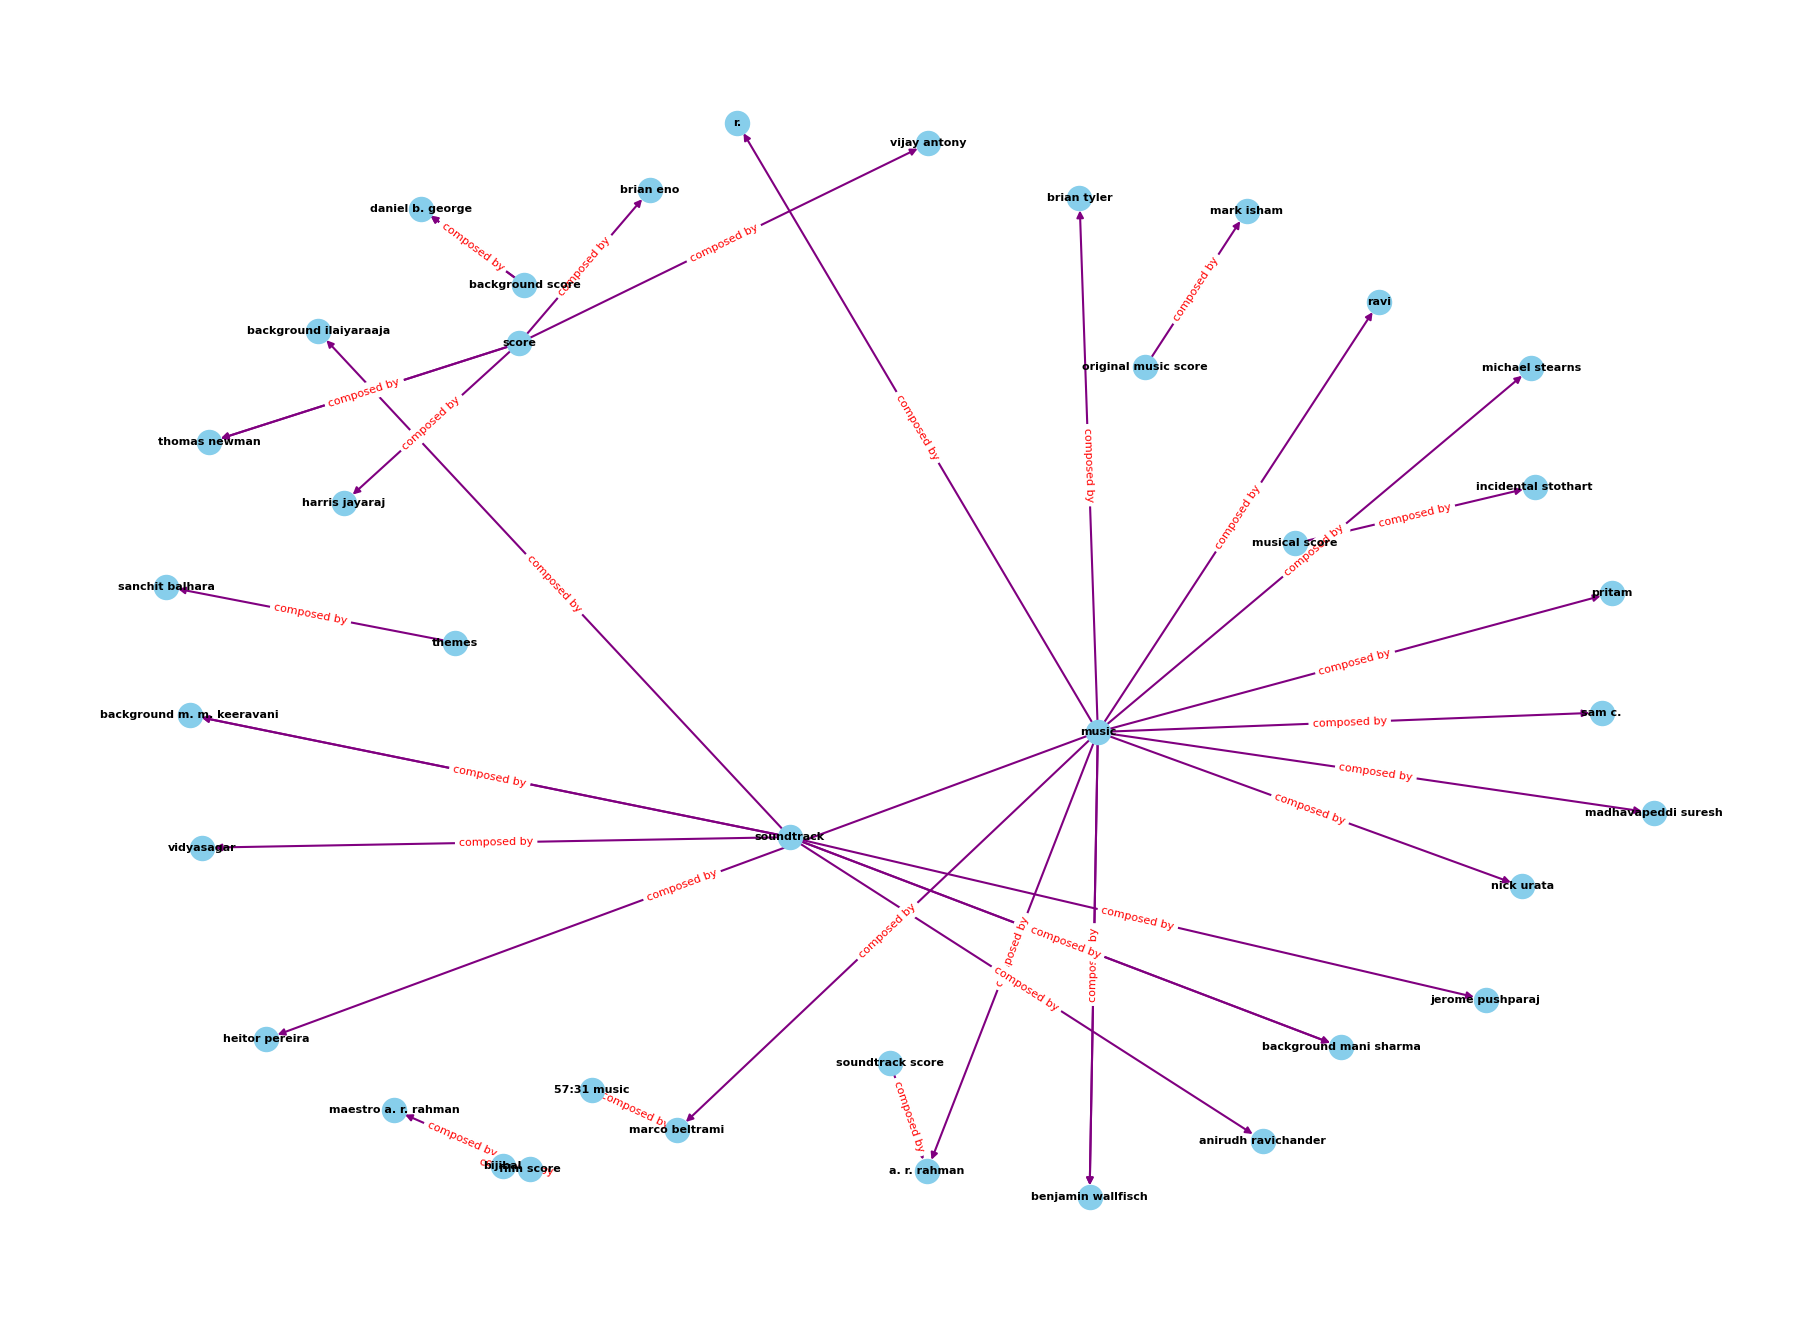

In [13]:
# Filter edges with 'composed by' relationship and create a directed multigraph
filtered_G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "composed by"], "source", "target", 
                                     edge_attr=True, create_using=nx.MultiDiGraph())

# Visualize the graph
plt.figure(figsize=(18, 13))
pos = nx.spring_layout(filtered_G, k=0.3)  # Adjust k to control node spacing
nx.draw(filtered_G, pos, with_labels=True, node_color="skyblue", font_size=8, font_weight="bold", edge_color="purple", width=1.5)

# Extract edge labels from 'edge' attribute or any specific attribute in kg_df
edge_labels = nx.get_edge_attributes(filtered_G, 'edge')  # Adjust to the correct attribute name
nx.draw_networkx_edge_labels(filtered_G, pos, edge_labels=edge_labels, font_size=8, font_color="red")

# Save and display the figure
plt.savefig("knowledge_graph_Newfiltered995.png", format="PNG")
plt.show()


##### ***Using pyvis to advanced visualization***

In [18]:
from pyvis.network import Network
# Initialize a NetworkX directed graph and pyvis Network object
net = Network(notebook=True, directed=True)

# Customize node appearance
for node in filtered_G.nodes():
    net.add_node(node, label=node, color="blue", size=19)

# Add edges with arrows to indicate direction
for edge in filtered_G.edges():
    net.add_edge(edge[0], edge[1], arrowStrikethrough=True)

# Generate the graph and display it inline
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 19
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      }
    },
    "color": {
      "color": "gray"
    }
  }
}
""")
net.show("directed_graph.html")


directed_graph.html


## Connect to Neo4j and Create Graph in Neo4j

In [19]:
# Connect to Neo4j
uri = "bolt://localhost:7687"
username = "neo4j"
password = "Reza1371"

driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

In [20]:
# Create index on the name property for optimization
session.run("CREATE INDEX IF NOT EXISTS FOR (n:Entity) ON (n.name)")

# Function to create nodes and relationships in Neo4j
def create_graph_in_neo4j(G):
    # First, create all nodes
    for node in G.nodes():
        session.run("MERGE (n:Entity {name: $name})", {"name": node})

    # Next, create all relationships without Cartesian product
    for source, target, data in G.edges(data=True):
        session.run(
            "MATCH (a:Entity {name: $source}) "
            "MATCH (b:Entity {name: $target}) "
            "MERGE (a)-[r:RELATED_TO {type: $label}]->(b)",
            {"source": source, "target": target, "label": data['edge']}
        )

create_graph_in_neo4j(G)

## Execute Cypher queries

### 1. Counting Total Entities

***This code snippet executes a Cypher query to count the total number of nodes labeled as Entity in the Neo4j database.***

In [21]:
query1 = "MATCH (n:Entity) RETURN COUNT(n) AS total_entities"
result = session.run(query1)
for record in result:
    print("\nTotal Number of Entities:", record["total_entities"])


Total Number of Entities: 7413


### 2. Querying Entity Names

***This query retrieves a limited number of nodes labeled as Entity and returns the name property of each of those nodes.***

In [22]:
query2 = "MATCH (n:Entity) RETURN n.name LIMIT 10"  # Change 10 to the desired number of entities
result = session.run(query2)
print("Some Entities in Neo4j:")
for record in result:
    print(record["n.name"])


Some Entities in Neo4j:
connie
own
later  scream
distance
christian
then  elder
temple
fire

outside cult him


### 3. Counting Total Relationships

***This query counts the total number of relationships.***

In [23]:
# Query to count total number of relationships
query3 = "MATCH ()-[r]->() RETURN COUNT(r) AS total_relationships"
result = session.run(query3)
for record in result:
    print("Total Number of Relationships:", record["total_relationships"])


Total Number of Relationships: 5865


### 4. Querying Entity Relationships

***This Cypher query retrieves and displays 10 random sample of relationships between entities.***

In [24]:
query4 = "MATCH (a:Entity)-[r:RELATED_TO]->(b:Entity) RETURN a.name AS source, r.type AS relationship, b.name AS target ORDER BY rand() LIMIT 10"
result = session.run(query4)
print("\nRelationships in Neo4j:")
for record in result:
    print(record["source"], record["relationship"], record["target"])



Relationships in Neo4j:
 pattinson vs. cam gigandet
zak penn rewrote then it
steven derek dana françois matthew robert catrini cast in undisclosed undisclosed roles
it rewritten with different  angle
traits are common live action
it was animated  3d
awards continued to least  1994
it was just sync
bryan hirota served as vfx supervisor
it sung by gagan himself


### 5. Finding Entities with the Most Outgoing Relationships

***This query counts the outgoing relationships for each Entity, sorts them in descending order, and displays the top 5 entities with the most outgoing connections:***

In [25]:
query5 = """
MATCH (n:Entity)-[r:RELATED_TO]->()
RETURN n.name AS entity, COUNT(r) AS out_degree
ORDER BY out_degree DESC
LIMIT 5
"""
result = session.run(query5)
print("\nEntities with Most Outgoing Relationships:")
for record in result:
    print(record["entity"], record["out_degree"])



Entities with Most Outgoing Relationships:
it 373
film 277
 246
he 149
they 93


### 6. Find the Shortest Path Between Two Entities

***This query finds the shortest path (if any) between two specific entities:***

In [26]:
query6 = """
MATCH (start:Entity {name: $start_name}), (end:Entity {name: $end_name}),
      p = shortestPath((start)-[*]-(end))
RETURN [n IN nodes(p) | n.name] AS path
"""

SourceEntityName = "mani sharma"
TargetEntityName = "nick urata"
params = {"start_name": SourceEntityName, "end_name": TargetEntityName}
result = session.run(query6, params)
print("\nShortest Path Between Two Entities:")
for record in result:
    print(record["path"])


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnboundedVariableLengthPatternWarning} {category: } {title: The provided pattern is unbounded, consider adding an upper limit to the number of node hops.} {description: Using shortest path with an unbounded pattern will likely result in long execution times. It is recommended to use an upper limit to the number of node hops in your pattern.} {position: line: 3, column: 24, offset: 98} for query: '\nMATCH (start:Entity {name: $start_name}), (end:Entity {name: $end_name}),\n      p = shortestPath((start)-[*]-(end))\nRETURN [n IN nodes(p) | n.name] AS path\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.CartesianProductWarning} {category: } {title: This query builds a cartesian product between disconnected patterns.} {description: If a part of a query contains multiple disconnected patterns, this will build a cartesian product between a


Shortest Path Between Two Entities:
['mani sharma', 'soundtrack', 'nick urata']


### 7. Top Entity Pairs by Relationship Type with Frequency Count

***This query can reveal which entities are frequently connected and the types of relationships that are dominant between them.***

In [27]:
# Advanced query to find the most common entity pairs per relationship type
query = """
MATCH (e1)-[r]->(e2)
RETURN type(r) AS relationship, e1.name AS entity1, e2.name AS entity2, COUNT(*) AS frequency
ORDER BY relationship, frequency DESC
LIMIT 10
"""
result = session.run(query)

print("\nMost Common Entity Pairs per Relationship Type:")
for record in result:
    print(f"Relationship: {record['relationship']}, Entity1: {record['entity1']}, Entity2: {record['entity2']}, Frequency: {record['frequency']}")



Most Common Entity Pairs per Relationship Type:
Relationship: RELATED_TO, Entity1: , Entity2: , Frequency: 33
Relationship: RELATED_TO, Entity1: i, Entity2: it, Frequency: 9
Relationship: RELATED_TO, Entity1: you, Entity2: me, Frequency: 5
Relationship: RELATED_TO, Entity1: film, Entity2: march, Frequency: 5
Relationship: RELATED_TO, Entity1: she, Entity2: him, Frequency: 4
Relationship: RELATED_TO, Entity1: principal photography, Entity2: august, Frequency: 4
Relationship: RELATED_TO, Entity1: filming, Entity2: april, Frequency: 4
Relationship: RELATED_TO, Entity1: principal  photography, Entity2: august, Frequency: 4
Relationship: RELATED_TO, Entity1: film, Entity2: may, Frequency: 3
Relationship: RELATED_TO, Entity1: film, Entity2: , Frequency: 3
